In [5]:
from collections import defaultdict
from pathlib import Path

import json

from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

In [2]:
def get_headers(df):
    keys = list(df.keys())[1:]
    headers = list()
    for key in keys:
        key = '_'.join(key.split('_')[:-2]).lower()
        if key not in headers:
            headers.append(key)
        else:
            break
    assert(len(set(headers)) == len(headers))
    return headers

In [6]:
pi = np.array([0,2,5,10,2,3,41,2,2])
print(pi[1+0::2])

[ 5  2 41  2]


In [17]:
data = defaultdict(dict)
for data_dir in Path('../experiments').iterdir():
    if data_dir.name in {'CIFAR10', 'CIFAR100'}:
        data[data_dir.name] = defaultdict(dict)
        for exp_dir in data_dir.iterdir():
            data[data_dir.name][exp_dir.name] = defaultdict(dict)
            for opt_dir in exp_dir.iterdir():
                print(opt_dir)
                avg_in_KG = 0
                avg_out_KG = 0
                avg_in_rank = 0
                avg_out_rank = 0
                avg_in_MC = 0
                avg_out_MC = 0
                avg_train_acc = 0
                avg_test_acc = 0
                avg_qc = 0
                empty = True
                avg_train_loss = 0
                avg_test_loss = 0
                for i, f in enumerate(opt_dir.iterdir()):
                    empty = False
                    if f.suffix == '.xlsx':
                        df = pd.read_excel(f)
                        headers = get_headers(df)
                        print(headers)
                        print(f.name)
                        df = df.T
                        in_KG = np.asarray(
                            df.iloc[headers.index('in_s') + 1::len(headers),
                                    :])
                        assert(len(in_KG[:, -1]) == 250)
                        out_KG = np.asarray(
                            df.iloc[headers.index('out_s') + 1::len(headers),
                                    :])
                        in_rank = np.asarray(
                            df.iloc[headers.index('in_rank') + 1::len(headers),
                                    :])
                        out_rank = np.asarray(
                            df.iloc[headers.index('out_rank') + 1::len(headers),
                                    :])
                        in_MC = np.asarray(
                            df.iloc[headers.index('in_condition') + 1::len(headers),
                                    :])
                        out_MC = np.asarray(
                            df.iloc[headers.index('out_condition') + 1::len(headers),
                                    :])
                        in_MC[in_MC == 0] = 500
                        out_MC[out_MC == 0] = 500
                        avg_in_KG += in_KG
                        avg_out_KG += out_KG
                        avg_in_rank += in_rank
                        avg_out_rank += out_rank
                        avg_in_MC += in_MC
                        avg_out_MC += out_MC
                        QC = np.arctan2((in_KG[-1, :] + out_KG[-1, :]), 
                            1 - 1 / ((in_MC[-1, :]  + out_MC[-1, :])))
                        QC = np.linalg.norm(QC) / np.sqrt(in_KG.shape[1])
                        avg_qc += QC
                        tag = 'test_acc1'
                        if 'test_acc1' not in headers:
                            tag = 'test_acc'
                            if 'test_acc' not in headers:
                                tag = 'acc'
                        test_acc = np.asarray(
                            df.iloc[headers.index(tag) + 1::len(headers), :])
                        tag = 'train_acc1'
                        avg_test_acc += test_acc
                        if 'train_acc1' not in headers:
                            tag = 'train_acc'
                        try:
                            train_acc = np.asarray(
                                df.iloc[headers.index(tag) + 1::len(headers), :])
                            avg_train_acc += train_acc
                        except Exception:
                            avg_train_acc += np.zeros_like(avg_train_acc)
                        train_loss = np.asarray(
                                    df.iloc[headers.index('train_loss') + 1::len(headers), :])
                        avg_train_loss += train_loss
                        try:
                            test_loss = np.asarray(
                                        df.iloc[headers.index('test_loss') + 1::len(headers), :])
                            avg_test_loss += test_loss
                        except Exception:
                            avg_test_loss += np.zeros_like(avg_test_loss)

                if empty:
                    print("EMPTY")
                    continue
                avg_in_KG /= (i + 1)
                avg_out_KG /= (i + 1)
                avg_in_rank /= (i + 1)
                avg_out_rank /= (i + 1)
                avg_in_MC /= (i + 1)
                avg_out_MC /= (i + 1)
                avg_train_acc /= (i + 1)
                avg_test_acc /= (i + 1)
                avg_qc /= (i + 1)
                avg_train_loss /= (i + 1)
                avg_test_loss /= (i + 1)
                data[data_dir.name][exp_dir.name][opt_dir.name] = {
                    "in_KG": avg_in_KG,
                    "out_KG": avg_in_KG,
                    "in_rank": avg_in_rank,
                    "out_rank": avg_in_rank,
                    "in_MC": avg_in_MC,
                    "out_MC": avg_in_MC,
                    "QC": avg_qc,
                    "train_loss": avg_train_loss,
                    "test_loss": avg_test_loss,
                    "train_acc": avg_train_acc,
                    "test_acc": avg_test_acc,
                }
                # n_grid = np.round(np.linspace(
                #     0, QC.shape[0]-1, QC.shape[1]))
                # n_grid = n_grid.astype(int)
                # plt.imshow(QC[n_grid, :].T,
                #            cmap='jet', vmin=0, vmax=np.pi/4)
                # locs, labels = plt.xticks()
                # x_labels = np.round(np.linspace(1, len(n_grid), len(locs)))
                # x_labels = x_labels.astype(int)
                # x_labels = n_grid[x_labels-1]
                # plt.xticks(locs, x_labels)
                # fname = f'figures/{data_dir.name}_{exp_dir.name}_{opt_dir.name}.png'
                

../experiments/CIFAR10/SENet18/SGD_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_SENet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_SENet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_SENet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-01-18-03-09-02_trial=2_ResNeXtCIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-01-18-07-25-18_trial=4_ResNeXtCIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-01-17-22-52-30_trial=0_ResNeXtCIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../e

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNeXtCIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNeXtCIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
../experiments/CIFAR10/ResNeXt/AdaGrad_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-01-27-19-50-38_trial=4_ResNeXtCIFAR_CIFAR10_AdaGradweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.01.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNeXtCIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNeXtCIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNeXtCIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=4_ResNet34CIFAR_CIFAR10_AdaMweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=3_ResNet34CIFAR_CIFAR10_AdaMweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
../experiments/CIFAR10/ResNet34/AdamP_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
t=4_ResNet34CIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', '

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet34CIFAR_CIFAR10_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR10/ResNet34/Adas_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet34CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNet34CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_s

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet50CIFAR_CIFAR10_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet50CIFAR_CIFAR10_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet50CIFAR_CIFAR10_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_ra

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet50CIFAR_CIFAR10_AdaBoundweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet50CIFAR_CIFAR10_AdaBoundweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
../experiments/CIFAR10/ResNet50/SGD_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet50CIFAR_CIFAR10_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s',

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=2_ResNet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=0_ResNet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=4_ResNet18CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet18CIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet18CIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet18CIFAR_CIFAR10_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_cond

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNet18CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet18CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet18CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_N

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet101CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet101CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet101CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet101CIFAR_CIFAR10_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet101CIFAR_CIFAR10_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR10/ResNet101/SAM_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet101CIFAR_CIFAR10_SAMweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_MobileNetV2CIFAR_CIFAR10_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR10/MobileNetV2/Adas_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_MobileNetV2CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_MobileNetV2CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ShuffleNetV2CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ShuffleNetV2CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ShuffleNetV2CIFAR_CIFAR10_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step

['train_acc', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc', 'test_loss']
2020-08-13 23_14_20.722971_SLS_None_trial=0_initlr=1.0net=ResNeXtCIFAR_dataset=CIFAR100.xlsx
['train_acc', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc', 'test_loss']
2020-08-14 02_06_38.198317_SLS_None_trial=1_initlr=1.0net=ResNeXtCIFAR_dataset=CIFAR100.xlsx
['train_acc', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc', 'test_loss']
2020-08-14 07_51_19.872493_SLS_None_trial=3_initlr=1.0net=ResNeXtCIFAR_dataset=CIFAR100.xlsx
['train_acc', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc', 'test_loss']
2020-08-14 04_59_16.269365_SLS_None_trial=2_initlr=1.0net=ResNeXtCIFAR_da

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNeXtCIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNeXtCIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
../experiments/CIFAR100/ResNeXt/AdamP_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNeXtCIFAR_CIFAR100_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNeXtCIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNeXtCIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNeXtCIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_ra

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_SENet18CIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_SENet18CIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_SENet18CIFAR_CIFAR100_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_ra

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNet34CIFAR_CIFAR100_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet34CIFAR_CIFAR100_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet34CIFAR_CIFAR100_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_c

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet34CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet34CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet34CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet50CIFAR_CIFAR100_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR100/ResNet50/Adas_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet50CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet50CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_ste

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNet50CIFAR_CIFAR100_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet50CIFAR_CIFAR100_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet50CIFAR_CIFAR100_SGDweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR100/ResNet50/SAM_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet18CIFAR_CIFAR100_SGDmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR100/ResNet18/SAM_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
t=3_ResNet18CIFAR_CIFAR100_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
t=2_ResNet18CIFAR_CIFAR100_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s'

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=0_ResNet18CIFAR_CIFAR100_AdaGradweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.01.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=1_ResNet18CIFAR_CIFAR100_AdaGradweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.01.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
results_trial=4_ResNet18CIFAR_CIFAR100_AdaGradweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.01.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_ra

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet18CIFAR_CIFAR100_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet18CIFAR_CIFAR100_SGDPweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR100/ResNet101/SLS
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet101CIFAR_CIFAR100_SLS_None_LR=1.0.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_conditio

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet101CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet101CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet101CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet101CIFAR_CIFAR100_SAMweight_decay=0.0005_momentum=0.9_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
../experiments/CIFAR100/ResNet101/Adas_StepDecay_Cutout
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet101CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet101CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gam

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_MobileNetV2CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_MobileNetV2CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'rank_velocity', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_MobileNetV2CIFAR_CIFAR100_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_EfficientNetB0CIFAR_CIFAR100_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_EfficientNetB0CIFAR_CIFAR100_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'learning_rate', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_EfficientNetB0CIFAR_CIFAR100_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 

ResNet34
0.12595183839340246
12.30684364358584
Spearman SpearmanrResult(correlation=0.8424242424242423, pvalue=0.0022200312259168407)
Kendal KendalltauResult(correlation=0.7333333333333333, pvalue=0.002212852733686067)
ResNet50
0.07501766867379207
48.27660236107478
Spearman SpearmanrResult(correlation=0.9300699300699302, pvalue=1.170222792865967e-05)
Kendal KendalltauResult(correlation=0.8181818181818181, pvalue=4.4129288920955584e-05)
ResNet18
0.14517484565575917
13.67167826294899
Spearman SpearmanrResult(correlation=0.6923076923076923, pvalue=0.008730317796749324)
Kendal KendalltauResult(correlation=0.5384615384615383, pvalue=0.010117397391702948)
ResNet101
0.055840463005840765
31.24969411224891
Spearman SpearmanrResult(correlation=0.8545454545454546, pvalue=0.0008066741521648989)
Kendal KendalltauResult(correlation=0.7090909090909091, pvalue=0.0015912097162097162)
ResNet34
0.1297733976033137
12.400531519386504
Spearman SpearmanrResult(correlation=0.8545454545454544, pvalue=0.0016368

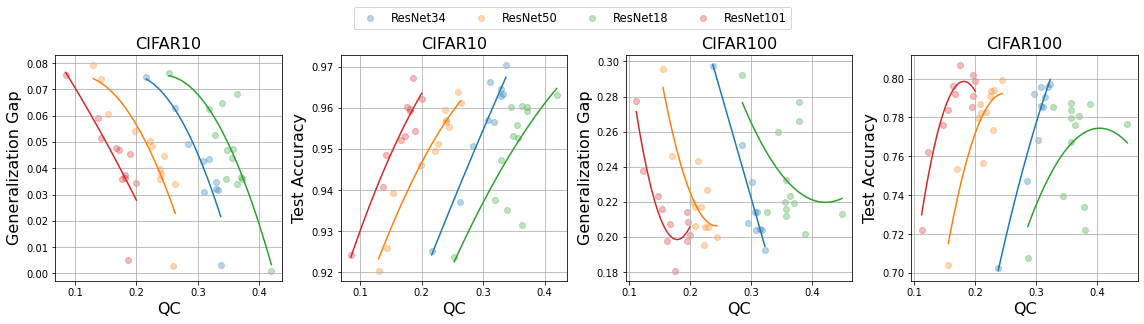

In [21]:
plt.close()
dataset_level = True
ALPHA = 1
POLYD = 2
FONTSIZE = 16
if dataset_level:
    fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
for i, (dataset, exps) in enumerate(data.items()):
    i *= 2
    for net, opts in exps.items():
        if 'ResNet' not in net:
            continue
        if not dataset_level:
            fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
        qc = list()
        gaps = list()
        accs = list()
        kgs = list()
        mcs = list()
        for opt, metrics in opts.items():
            if net == 'ResNet34' and opt == 'SGD_StepDecay':
                continue
            if net == 'ResNet101' and opt == 'SLS':
                continue
            QC = np.arctan2((metrics['in_KG'][-1, :] + metrics['out_KG'][-1, :]), 
                            1 - ALPHA / ((metrics['in_MC'][-1, :]  + metrics['out_MC'][-1, :])))
            try:
                QC = np.linalg.norm(QC) / np.sqrt(metrics['in_KG'].shape[1])
                if not np.isnan(QC):
                    qc.append(QC)
                    test_acc = np.max(metrics['test_acc'][:, 0])
                    gap = np.max(metrics['train_acc'][:, 0]) - test_acc
                    accs.append(test_acc)
                    gaps.append(gap)
                    kgs.append(metrics['out_KG'][-1, :])
                    mcs.append(metrics['out_MC'][-1, :])
                    if not dataset_level:
                        axs[0].scatter([QC], [gap], label=opt)
                        axs[1].scatter([QC], [test_acc], label=opt)
            except Exception:
                pass
        qc = np.array(qc)
        gaps = np.array(gaps)
        accs = np.array(accs)
        poly_x = np.linspace(np.min(qc), np.max(qc))

        if dataset_level:
            coeff = np.polyfit(qc, gaps, POLYD)
            poly = np.poly1d(coeff)
            fitted = poly(poly_x)
            axs[0+i].plot(poly_x, fitted, 
                        zorder=100)
            if i == 0:
                axs[0+i].scatter(qc, gaps, label=net, alpha=0.3, zorder=1)
            else:
                axs[0+i].scatter(qc, gaps, alpha=0.3, zorder=1)
            coeff = np.polyfit(qc, accs, POLYD)
            poly = np.poly1d(coeff)
            fitted = poly(poly_x)
            axs[1+i].plot(poly_x, fitted, zorder=100)
            axs[1+i].scatter(qc, accs, alpha=0.3, zorder=1)
        print(net)
        print(np.mean(kgs))
        print(np.mean(mcs))
        print('Spearman', stats.spearmanr(qc, -gaps))
        print('Kendal', stats.kendalltau(qc, -gaps))
        if not dataset_level:
            axs[0].set_title(f'{dataset}-{net}')
            axs[1].set_title(f'{dataset}-{net}')
            axs[0].set_xlabel("QC")
            axs[1].set_xlabel("QC")
            axs[0].set_ylabel("Train-Test Gap")
            axs[1].set_ylabel("Test Accuracy")
#             if dataset == 'CIFAR10':
#                 axs[0].set_ylim(-0.1, 0.2)
#                 axs[1].set_ylim(0.9, 0.98)
#             else:
#                 axs[0].set_ylim(0.0, 0.4)
#                 axs[1].set_ylim(0.6, 0.83)
            axs[0].set_aspect(1. / axs[0].get_data_ratio(), adjustable='box')
            axs[1].set_aspect(1. / axs[1].get_data_ratio(), adjustable='box')
            plt.legend(bbox_to_anchor=(1, 1), ncol=3)
            plt.show()
            plt.close()
    if dataset_level:
        axs[0+i].set_title(f'{dataset}', fontsize=FONTSIZE)
        axs[1+i].set_title(f'{dataset}', fontsize=FONTSIZE)
        axs[0+i].set_xlabel("QC", fontsize=FONTSIZE)
        axs[1+i].set_xlabel("QC", fontsize=FONTSIZE)
        axs[0+i].set_ylabel("Generalization Gap", fontsize=FONTSIZE)
        axs[1+i].set_ylabel("Test Accuracy", fontsize=FONTSIZE)
#         axs[0+i].set_xscale('log')
#         axs[1+i].set_xscale('log')
#         if dataset == 'CIFAR10':
#             axs[0].set_ylim(-0.1, 0.2)
#             axs[1].set_ylim(0.9, 0.98)
#         else:
#             axs[0].set_ylim(0.0, 0.4)
#             axs[1].set_ylim(0.6, 0.83)
        axs[0+i].set_aspect(1. / axs[0+i].get_data_ratio(), adjustable='box')
        axs[1+i].set_aspect(1. / axs[1+i].get_data_ratio(), adjustable='box')
        for j in range(2):
            ax = axs[j+i]
            box = ax.get_position()
            box.y0 += 0.01
            box.y1 += 0.01
            ax.set_position(box)
            ax.grid(True, zorder=0)
    
if dataset_level:
    fig.legend(loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=4, prop={'size': 11.5})
    fig.tight_layout()
    fig.savefig(f'figures/resnets_qc_{POLYD}d.png', bbox_inches='tight')
    plt.show()
    plt.close()
        

In [7]:
torch.save(data, 'data/data_full.pt')